In [3]:
pip install numpy pandas matplotlib scipy statsmodels arch yfinance

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings as w
w.filterwarnings('ignore')
from scipy.stats import skew, kurtosis, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
import yfinance as yf  # Install with: pip install yfinance

In [15]:
data = yf.download("FXI", start="2010-01-01", end="2024-04-01")
print(data.columns)
print(data.head())


[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'FXI'),
            (  'High', 'FXI'),
            (   'Low', 'FXI'),
            (  'Open', 'FXI'),
            ('Volume', 'FXI')],
           names=['Price', 'Ticker'])
Price           Close       High        Low       Open    Volume
Ticker            FXI        FXI        FXI        FXI       FXI
Date                                                            
2010-01-04  30.030777  30.051660  29.752329  29.759289  16220300
2010-01-05  30.650324  30.664247  30.392759  30.504139  16484500
2010-01-06  31.019276  31.033198  30.859168  30.935739  11460900
2010-01-07  30.538939  30.657281  30.371870  30.587667  23195800
2010-01-08  30.629442  30.636402  30.288340  30.469334  12764700


In [23]:
# Step 1: Download FXI ETF data
data = yf.download("FXI", start="2010-01-01", end="2024-04-01")

# Extract the 'Close' prices from the MultiIndex DataFrame
close_prices = data['Close']['FXI']

# Display first few rows
print("Sample Close Prices:\n", close_prices.head())

[*********************100%***********************]  1 of 1 completed

Sample Close Prices:
 Date
2010-01-04    30.030777
2010-01-05    30.650324
2010-01-06    31.019276
2010-01-07    30.538939
2010-01-08    30.629442
Name: FXI, dtype: float64


In [24]:
# Step 2: Compute log returns
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# Display first few log returns
print("\nSample Log Returns:\n", log_returns.head())



Sample Log Returns:
 Date
2010-01-05    0.020420
2010-01-06    0.011966
2010-01-07   -0.015606
2010-01-08    0.002959
2010-01-11    0.001590
Name: FXI, dtype: float64


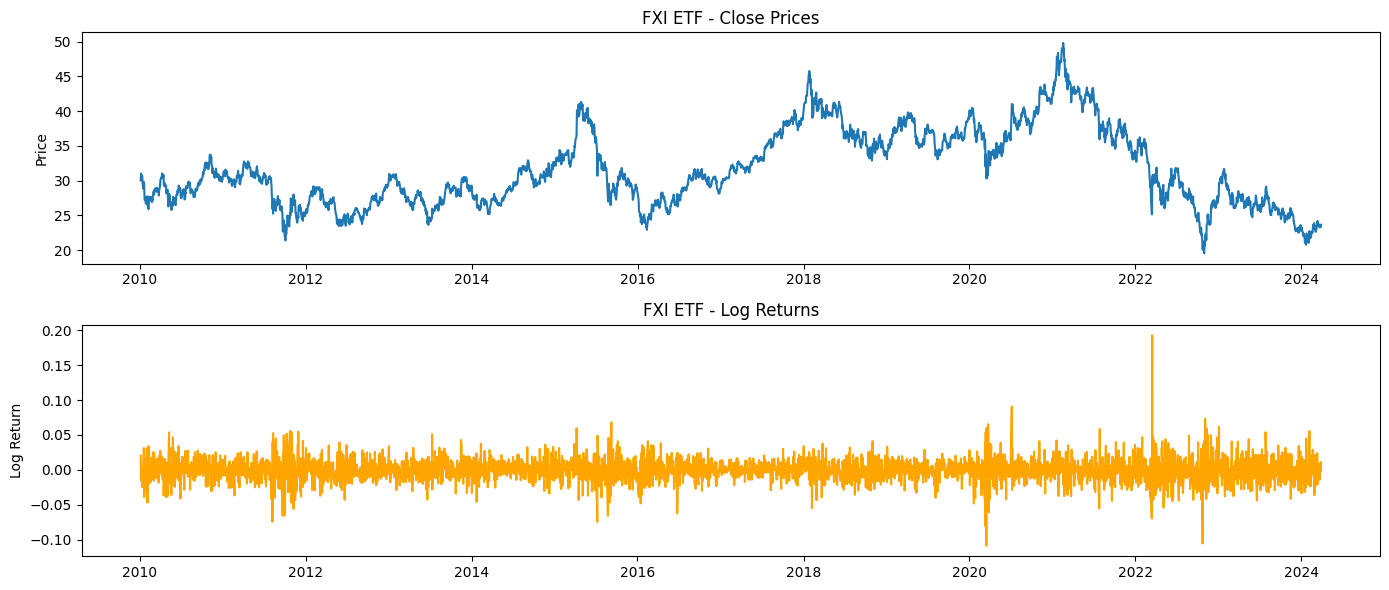

In [25]:
# Step 3: Plot Close Prices and Log Returns
plt.figure(figsize=(14, 6))

# Plot close prices
plt.subplot(2, 1, 1)
plt.plot(close_prices)
plt.title('FXI ETF - Close Prices')
plt.ylabel('Price')

# Plot log returns
plt.subplot(2, 1, 2)
plt.plot(log_returns, color='orange')
plt.title('FXI ETF - Log Returns')
plt.ylabel('Log Return')
plt.tight_layout()
plt.show()


In [26]:
# Step 4: Descriptive stats
mean_return = log_returns.mean()
std_return = log_returns.std()
skewness = skew(log_returns)
kurt = kurtosis(log_returns)
jb_stat, jb_pvalue = jarque_bera(log_returns)

print(f"Mean: {mean_return:.6f}")
print(f"Standard Deviation: {std_return:.6f}")
print(f"Skewness: {skewness:.6f}")
print(f"Kurtosis: {kurt:.6f}")
print(f"Jarque-Bera Stat: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")


Mean: -0.000067
Standard Deviation: 0.016800
Skewness: 0.276981
Kurtosis: 7.087834
Jarque-Bera Stat: 7543.7321, p-value: 0.0000


<Figure size 800x400 with 0 Axes>

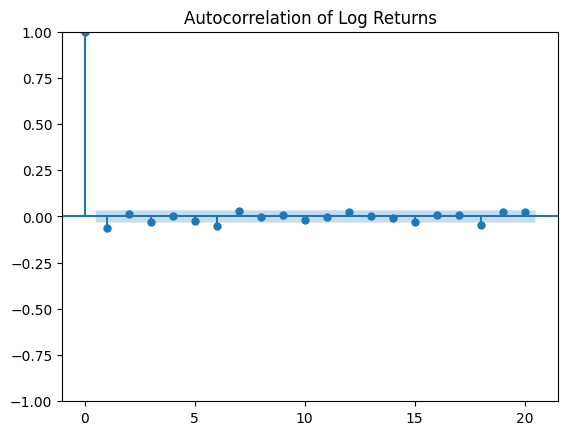

In [30]:
# Step 5: Autocorrelation plot
plt.figure(figsize=(8, 4))
plot_acf(log_returns, lags=20)
plt.title('Autocorrelation of Log Returns')
plt.show()


In [31]:
# Step 6: Fit a GARCH(1,1) model
model = arch_model(log_returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')

# Summary of the model
print(garch_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    FXI   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9851.30
Distribution:                  Normal   AIC:                          -19694.6
Method:            Maximum Likelihood   BIC:                          -19669.9
                                        No. Observations:                 3582
Date:                Tue, Apr 08 2025   Df Residuals:                     3581
Time:                        15:29:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.1061e-04  3.524e-06     88.149      0.000 [3.

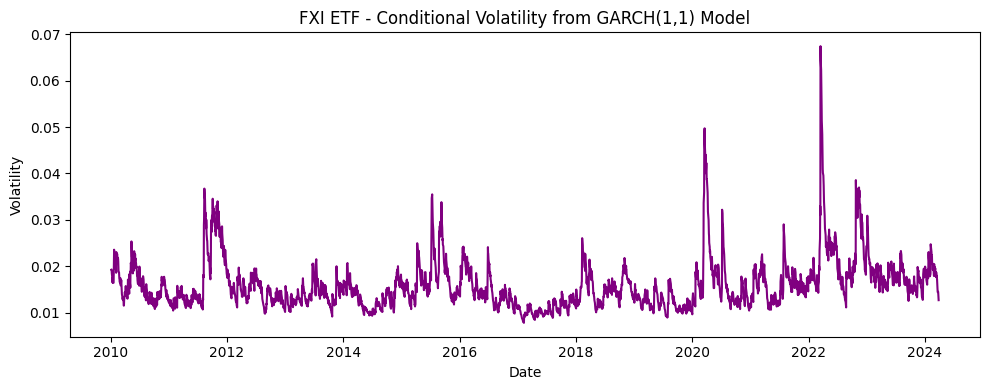

In [32]:
# Step 7: Plot the conditional volatility
plt.figure(figsize=(10, 4))
plt.plot(garch_fit.conditional_volatility, color='purple')
plt.title('FXI ETF - Conditional Volatility from GARCH(1,1) Model')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [33]:
# Save conditional volatility and returns to CSV
results_df = pd.DataFrame({
    'Log_Returns': log_returns,
    'Conditional_Volatility': garch_fit.conditional_volatility
})
results_df.to_csv("FXI_GARCH_results.csv")
print("Results saved to 'FXI_GARCH_results.csv'")


Results saved to 'FXI_GARCH_results.csv'


In [34]:
# Forecast next 10 days of volatility
forecast = garch_fit.forecast(horizon=10)
print(forecast.variance[-1:])


                h.01     h.02      h.03      h.04      h.05     h.06  \
Date                                                                   
2024-03-28  0.000158  0.00016  0.000163  0.000165  0.000168  0.00017   

                h.07      h.08      h.09      h.10  
Date                                                
2024-03-28  0.000172  0.000174  0.000176  0.000179  
